In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

import tensorflow as tf

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,tensorflow

Ethen 2016-08-03 23:11:29 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
tensorflow 0.9.0


# Deep Learning (Almost) from scratch

Table of Contents:

- [Neural Network Introduction](#nn)
- [Tensorflow Implementation](#tf)
- [Tricks and Tips](#tt)

<a name='nn'></a>

## Neural Network Introduction

The basic computational unit of the brain is a **neuron**. Approximately 86 billion neurons can be found in the human nervous system and they are connected with approximately 10^14 - 10^15 **synapses**. The diagram below shows a cartoon drawing of the mathematical model. Each neuron receives input signals from its **dendrites** and produces output signals along its (single) **axon**. The axon eventually branches out and connects via synapses to dendrites of other neurons. 

<img src='images/neuron_model.jpeg' width="60%">

In the computational model of a neuron, the signals that travel along the axons (e.g. \\(x_0\\)) interact multiplicatively (e.g. \\(w_0 x_0\\)) with the dendrites of the other neuron based on the synaptic strength at that synapse (e.g. \\(w_0\\)). The idea is that the synaptic strengths (the weights \\(w\\)) are learnable and control the strength of influence (and its direction: excitory (positive weight) or inhibitory (negative weight)) of one neuron on another. In the basic model, the dendrites carry the signal to the cell body where they all get summed (e.g. $\sum_iw_ix_i + b$, there will always be an extra bias term $b$). If the final sum is above a certain threshold, the neuron can *fire*, sending a spike along its axon. In the computational model, we assume that the precise timings of the spikes do not matter, and that only the frequency of the firing communicates information. Based on this interpretation, we model the *firing rate* of the neuron with an **activation function** \\(f\\). Historically, a common choice of activation function is the **sigmoid function** \\(\sigma(x) = 1/(1+e^{-x})\\), since it takes a real-valued input (the signal strength after the sum) and squashes it to range between 0 and 1. We will see details of these activation functions later.

### Neural Network Architectures

Neural Networks are modeled as collections of neurons that are connected in an acyclic graph. In other words, the outputs of some neurons can become inputs to other neurons. Cycles are not allowed since that would imply an infinite loop in the forward pass of a network. Instead of an amorphous blobs of connected neurons, Neural Network models are often organized into distinct layers of neurons. For regular neural networks, the most common layer type is the **fully-connected layer** in which  neurons between two adjacent layers are fully pairwise connected, but neurons within a single layer share no connections. Below is an example Neural Network of a 3-layer neural network with an inputs layer of size 3, two hidden layers each having size 4 and an output layer with size 1. Notice that in both cases there are connections (synapses) between neurons across layers, but not within a layer (Yes, they look like a bunch of softmax stacked together).

<img src="images/neural_net.jpeg" width="60%">

**Naming conventions.** You may also hear these networks interchangeably referred to as *"Artificial Neural Networks"* (ANN) or *"Multi-Layer Perceptrons"* (MLP) and when the network consists of more than one hidden layer, it is essentially a **deep learning** model. Notice that when we say N-layer neural network, we do not count the input layer. 

**Input layer** The number of nodes in the **input layer** is determined by the dimensionality (number of feature columns) of our data.

**Hidden layer** The most interesting task for neural network is that we can choose the size (the number of nodes) of the hidden layer and the number of hidden layers. The more nodes we put into the hidden layer and the more hidden layers we add, the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. Choosing the size of the hidden layer will always depends on your specific problem (usually determined by cross validation) and it is more of an art than a science. We will play with the number of nodes in the hidden later later on and see how it affects our output.

**Output layer** The size of (number of nodes) **output layer** is determined by the number of classes we have. Unlike all **hidden layers**, the output layer neurons most commonly do not have an activation function. This is because the last output layer is usually taken to represent the class scores (e.g. in classification), which are arbitrary real-valued numbers, or some kind of real-valued target (e.g. in regression). 

**Sizing neural networks** The two metrics that people commonly use to measure the size of neural networks are the number of neurons, or more commonly the number of parameters. Working with the example networks in the above picture: The network has 4 + 4 + 1 = 9 neurons, [3 x 4] + [4 x 4] + [4 x 1] = 12 + 16 + 4 = 32 weights (number of lines the in pictue) and 4 + 4 + 1 = 9 biases (these are not shown in the picture), for a total of 41 learnable parameters.

To give you some context, modern Convolutional Networks contain on orders of 100 million parameters and are usually made up of approximately 10-20 layers.

### Feed-forward computation

One of the primary reasons that Neural Networks are organized into layers is that this structure makes it very simple and efficient to compute using matrix vector operations (just like softmax). Working with the example three-layer neural network in the diagram above, the input would be a [3x1] vector. All connection strengths for a layer can be stored in a single matrix. For example, the first hidden layer's weights `W1` would be of size [4x3], and the biases for all units would be in the vector `b1`, of size [4x1]. Here, every single neuron has its weights in a row of `W1`, so the matrix vector multiplication `np.dot(W1,x)` evaluates the activations of all neurons in that layer. Similarly, `W2` would be a [4x4] matrix that stores the connections of the second hidden layer, and `W3` a [1x4] matrix for the last (output) layer. The full forward pass of this 3-layer neural network is then simply three matrix multiplications, interwoven with the application of the activation function:

```python

# forward-pass of a 3-layer neural network:
f = lambda x: 1 / ( 1 + np.exp(-x) ) # activation function (use sigmoid)
x = np.random.randn(3, 1) # random input vector of three numbers (3x1)
h1 = f(np.dot(W1, x) + b1) # calculate first hidden layer activations (4x1)
h2 = f(np.dot(W2, h1) + b2) # calculate second hidden layer activations (4x1)
out = np.dot(W3, h2) + b3 # output neuron (1x1)

```

In the above code, `W1,W2,W3,b1,b2,b3` are the learnable parameters of the network. Notice also that instead of having a single input column vector, the variable `x` could hold an entire batch of training data (where each input example would be a column of `x`) and then all examples would be efficiently evaluated in parallel. Notice that the final Neural Network layer usually doesn't have an activation function as it represents a (real-valued) class score in a classification setting. Thus we can apply the softmax function to convert it into our probability.

> The forward pass of a fully-connected layer corresponds to one matrix multiplication followed by a bias offset and an activation function.

<a name='tf'></a>

## Tensorflow Implementation

A lot of it should look extremely familiar after going through the softmax implementation.

In [3]:
# Import MNIST data
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets( "/tmp/data/", one_hot = True )

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels

# global parameters
learning_rate = 0.005
epochs = 20
batch_size = 2048

# network parameters (only one hidden layer)
n_hidden_1 = 256 # 1st hidden layer's size (number of nodes)
n_input = X_train.shape[1] # MNIST data input (image's shape: 28*28)
n_class = y_train.shape[1] # MNIST total classes (0-9 digits)

# place holder for the data and label
X = tf.placeholder( tf.float32, [None, n_input] )
y = tf.placeholder( tf.float32, [None, n_class] )

# store layers' weight & bias
params = {
    'W1': tf.Variable( tf.random_normal([ n_input, n_hidden_1 ]) ),
    'W2': tf.Variable( tf.random_normal([ n_hidden_1, n_class ]) ),
    'b1': tf.Variable( tf.random_normal([n_hidden_1]) ),
    'b2': tf.Variable( tf.random_normal([n_class]) ),
}

# Hidden layer with sigmoid activation
# Output layer with softmax activation
layer1 = tf.nn.sigmoid( tf.matmul( X, params['W1'] ) + params['b1'] )
output = tf.nn.softmax( tf.matmul( layer1, params['W2'] ) + params['b2'] )
output = tf.clip_by_value( output, 1e-10, 1.0 )
# cross entropy cost function
cross_entropy = tf.reduce_mean( -tf.reduce_sum( y * tf.log(output), 1 ) )

# Define loss and optimizer and initializing the variables,
# more description on adam optimizer later
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
init = tf.initialize_all_variables()

# predicted accuracy
correct_prediction = tf.equal( tf.argmax( y, 1 ), tf.argmax( output, 1 ) )
accuracy = tf.reduce_mean( tf.cast( correct_prediction, tf.float32 ) )

> [StackOverflow](http://stackoverflow.com/questions/33712178/tensorflow-nan-bug) In some samples, certain classes could be excluded with certainty after a while, resulting in output probability = 0 for that sample. This yields a log(0) for the cross entropy calculation for that particular sample/class. Hence the cost will become NaN. The way to resolve this is to use `tf.clip_by_value` to specify a boundary for the maximum and minimum value.

In [5]:
# record the training history so we can visualize them later
cost_train_history = []
acc_train_history  = []
acc_test_history   = []

with tf.Session() as sess:
    sess.run(init)
    
    # epochs is the number of times that we loop through the 
    # entire training data
    iterations = int( epochs * X_train.shape[0] / batch_size )
    for i in range(iterations):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        _, acc_train, c_train = sess.run( [ optimizer, accuracy, cross_entropy ], 
                                          feed_dict = { X: X_batch, y: y_batch } )       
        if i % 50 == 0:
            print(c_train)
        
        # average cost across the batch size
        cost = c_train / batch_size
        cost_train_history.append(cost)
        acc_train_history.append(acc_train)
        
        acc_test = sess.run( accuracy, feed_dict = { X: X_test, y: y_test } )
        acc_test_history.append(acc_test)

17.5924
1.08718
0.700584
0.498998
0.390937
0.278459
0.285028
0.210471
0.187714
0.146414
0.131872


In [6]:
acc_test_history[len(acc_test_history) - 1]

0.93129998

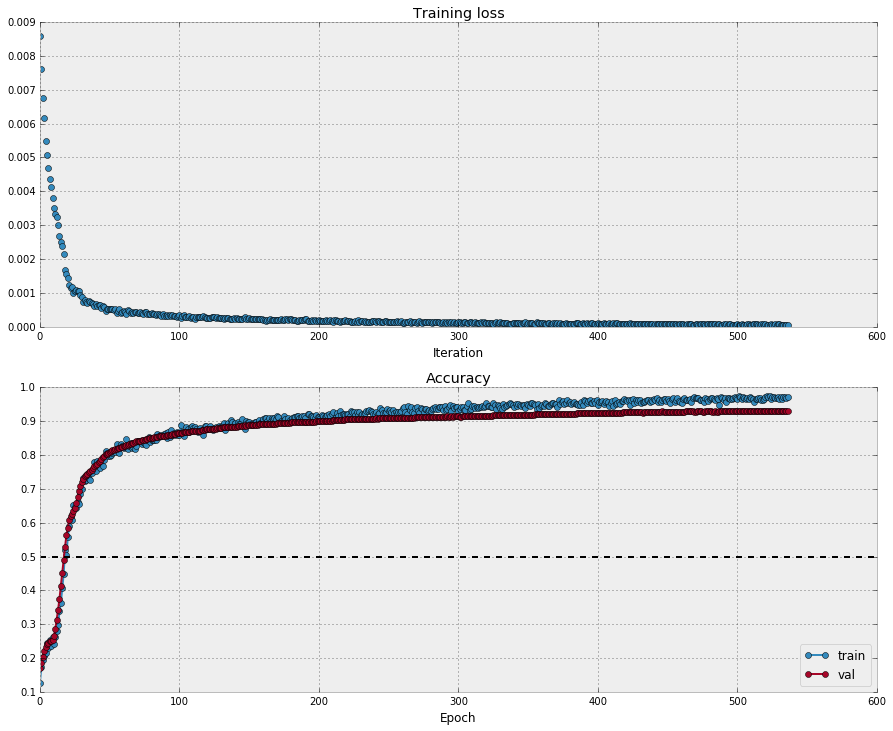

In [7]:
# visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(cost_train_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot( acc_train_history, '-o', label = 'train' )
plt.plot( acc_test_history, '-o', label = 'val' )
plt.axhline( y = 0.5, color = 'black', linestyle = '--' )
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Again, after specifying the structure of our network Tensorflow will automatically compute the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$.

To calculate these gradients we use the famous *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. We won't go into detail how backpropagation works, but there are many excellent explanations floating around the web. ([Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) or [Course Notes: Backpropagation](http://cs231n.github.io/optimization-2/) and [A Step by Step Backpropagation Example](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)) 

<a name='tt'></a>

## Tricks and Tips

In [8]:
def plot_activation(kind):
    x = np.arange( -5, 5, 0.005 )

    if kind == 'sigmoid':
        y = 1.0 / ( 1.0 + np.exp(-x))
    elif kind == 'tanh':
        e_p = np.exp(x)
        e_n = np.exp(-x)
        y = ( e_p - e_n ) / ( e_p + e_n )  
    else: # relu
        y = np.maximum( 0, x )

    plt.plot( x, y )
    plt.title(kind)
    plt.show()

### Commonly Used Activation Functions

Every activation function (or *non-linearity*) takes a single number and performs a certain fixed mathematical operation on it. There are several activation functions you may encounter in practice:

**Sigmoid.** The sigmoid non-linearity has the mathematical form, note that $x$ is simply the input value:

$$\sigma(x) = 1 / (1 + e^{-x})$$

And its first derivative (the first derivative of the activation are used in the backpropagation stage):

$$\frac{d\sigma}{dx} = (1-\sigma)\sigma$$

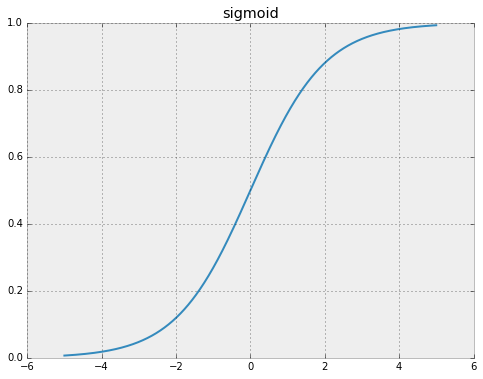

In [9]:
plot_activation( kind = 'sigmoid' )

It takes a real-valued number and "squashes" it into range between 0 and 1. In particular, large negative numbers will approximately become 0 and large positive numbers approximately become 1. The sigmoid function has seen frequent use historically since it has a nice interpretation as the firing rate of a neuron: from not firing at all (0) to fully-saturated firing at an assumed maximum frequency (1). In practice, the sigmoid non-linearity has recently fallen out of favor and it is rarely ever used. It has two major drawbacks: 

- *Sigmoids saturate and kill gradients*. A very undesirable property of the sigmoid neuron is that when the neuron's activation saturates at either tail of 0 or 1, the gradient at these regions is almost zero. During backpropagation, this (local) gradient will be multiplied to the gradient of this gate's output for the whole objective. Therefore, if the local gradient is very small, it will effectively "kill" the gradient and almost no signal will flow through the neuron to its weights and recursively to its data. Additionally, one must pay extra caution when initializing the weights of sigmoid neurons to prevent saturation. For example, if the initial weights are too large then most neurons would become saturated and the network will barely learn.
- *Sigmoid outputs are not zero-centered*. This is undesirable since neurons in later layers of processing in a Neural Network (more on this soon) would be receiving data that is not zero-centered. This has implications on the dynamics during gradient descent, because if the data coming into a neuron is always positive (e.g. $x > 0$ elementwise in $f = w^Tx + b$ ), then during backpropagation, the gradient on the weights $w$ will become either all be positive, or all negative (depending on the gradient of the whole expression $f$). This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights. However, notice that once these gradients are added up across a batch of data the final update for the weights can have variable signs, somewhat mitigating this issue. Therefore, this is an inconvenience but it has less severe consequences compared to the saturated activation problem above.

**Tanh.** Mathematical form:

$$tanh(z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$$

The first derivative for Tanh is:

$$1 - tanh(z)^2$$

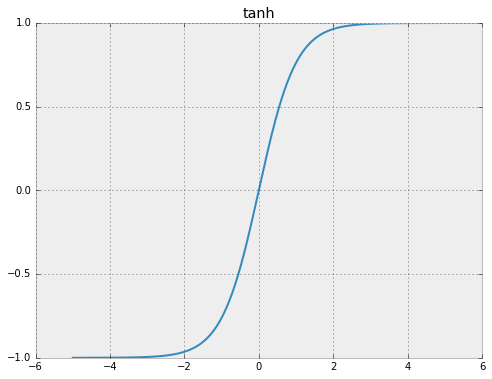

In [10]:
plot_activation( kind = 'tanh' )

It squashes a real-valued number to the range [-1, 1]. Like the sigmoid neuron, its activations saturate, but unlike the sigmoid neuron its output is zero-centered. Therefore, in practice the *tanh non-linearity is always preferred to the sigmoid nonlinearity.* Also note that the tanh neuron is simply a scaled sigmoid neuron, in particular the following holds: $\tanh(x) = 2 \sigma(2x) -1$.

**ReLU.** The Rectified Linear Unit has become very popular recently (as of 2016). It computes the function:

$$f(x) = \max(0, x)$$ 

The first derivative for ReLU is:

$$
\frac{df}{dx} = 
\begin{cases} 
1 & x > 0 \\ 
0 & x \leq 0
\end{cases}
$$

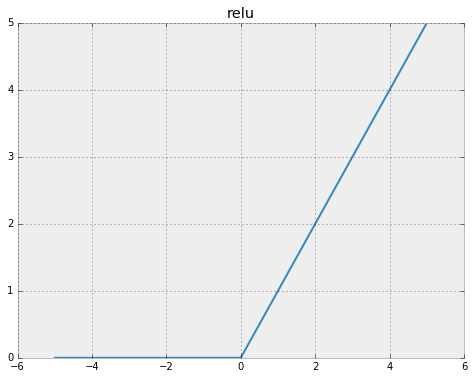

In [11]:
plot_activation( kind = 'relu' )

The activation is simply thresholded at zero. There are several pros and cons to using the ReLUs: 

- (+) It was found to greatly accelerate the convergence of stochastic gradient descent compared to the sigmoid/tanh functions. It is argued that this is due to its linear, non-saturating form.
- (+) Compared to tanh/sigmoid neurons that involve expensive operations (exponentials, etc.), the ReLU can be implemented by simply thresholding a matrix of activations at zero.
- (-) Unfortunately, ReLU units can be fragile during training and can "die". For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be "dead" (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue.

**Leaky ReLU.** Leaky ReLUs are one attempt to fix the "dying ReLU" problem. Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slope (of 0.01, or so). That is, the function computes \\(f(x) = \mathbb{1}(x < 0) (\alpha x) + \mathbb{1}(x>=0) (x) \\) where \\(\alpha\\) is a small constant. Some people report success with this form of activation function, but the results are not always consistent. The slope in the negative region can also be made into a parameter of each neuron, as seen in **PReLU**. However, the consistency of the benefit across tasks is presently unclear.

Derivation of the first derivative of sigmoid and tanh for those that are interested. [[Link](https://theclevermachine.wordpress.com/2014/09/08/derivation-derivatives-for-common-neural-network-activation-functions/)]

### Model Complexity

Note that as we increase the size and number of layers in a network, the complexity of the network increases. That is, the space of representable functions grows since the neurons can collaborate to express many more different functions. For example, suppose we had a binary classification problem in two dimensions. We could train three separate neural network classifiers, each having one hidden layer of different size:

![](images/layer_size.png)

The data are shown as circles colored by their class, and the decision regions by a trained neural network are shown underneath.

In the diagram above, we can see that networks with more neurons can express more complicated functions. However, this is both a blessing (since we can learn to classify more complicated data) and a curse (since it is easier to overfit the training data). Like all machine learning models, overfitting occurs when a model with high complexity fits the noise in the data instead of the (assumed) underlying relationship. The plot shows that the model with 20 hidden neurons fits all the training data but at the cost of segmenting the space into many disjoint red and green decision regions. The model with 3 hidden neurons only has the representational power to classify the data in broad strokes. It models the data as two blobs and interprets the few red points inside the green cluster as outliers (noise). In practice, this could lead to better generalization on the test set.

> Based on our discussion above, it seems that smaller neural networks can be preferred if the data is not complex enough to prevent overfitting. However, this is incorrect - there are many other preferred ways to prevent overfitting in networks that we will see later (such as L2 regularization, dropout, input noise). In practice, it is always better to use these methods to control overfitting instead of the number of neurons.

In practice, what you find is that if you train a small network the final loss can display a good amount of variance - in some cases you get lucky and converge to a good place but in some cases you get trapped in one of the bad minima. On the other hand, if you train a large network you’ll start to find many different solutions, but the variance in the final achieved loss will be much smaller. In other words, all solutions are about equally as good, and rely less on the luck of random initialization.

To reiterate, the regularization strength is the preferred way to control the overfitting of a neural network. We can look at the results achieved by three different settings:

![](images/regularizations.png)

The effects of regularization strength: Each neural network above has 20 hidden neurons, but changing the regularization strength makes its final decision regions smoother with a higher regularization.

### Regularization

There are several ways to prevent overfitting, the first one is **Regularizations**.

**L2 regularization** is perhaps the most common form of regularization. It can be implemented by penalizing the squared magnitude of all parameters directly in the objective. That is, for every weight \\(w\\) in the network, we add the term \\(\frac{1}{2} \lambda w^2\\) to the objective, where \\(\lambda\\) is the regularization strength. It is common to see the factor of \\(\frac{1}{2}\\) in front because then the gradient of this term with respect to the parameter \\(w\\) is simply \\(\lambda w\\) instead of \\(2 \lambda w\\). The L2 regularization has the intuitive interpretation of heavily penalizing peaky weight vectors and preferring diffuse weight vectors. This encourages the network to use all of its inputs a little rather that some of its inputs a lot.

**L1 regularization** is another relatively common form of regularization, where for each weight \\(w\\) we add the term \\(\lambda  \mid w \mid\\) to the objective. It is possible to combine the L1 regularization with the L2 regularization: \\(\lambda_1 \mid w \mid + \lambda_2 w^2\\) (this is called Elastic net regularization). The L1 regularization has the intriguing property that it leads the weight vectors to become sparse during optimization (i.e. very close to exactly zero). In other words, neurons with L1 regularization end up using only a sparse subset of their most important inputs and become nearly invariant to the "noisy" inputs. 

In comparison, final weight vectors from L2 regularization are usually diffuse, small numbers. In practice, if you are not concerned with explicit feature selection, L2 regularization can be expected to give superior performance over L1. **Note that for both regularization we do not regularize the bias**.

**Max norm constraints**. Another form of regularization is to enforce an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. In practice, this corresponds to performing the parameter update as normal, and then enforcing the constraint by clamping the weight vector \\(\vec{w}\\) of every neuron to satisfy \\(\Vert \vec{w} \Vert_2 < c\\). Typical values of \\(c\\) are on orders of 3 or 4. Some people report improvements when using this form of regularization. One of its appealing properties is that network cannot "explode" even when the learning rates are set too high because the updates are always bounded.

### Dropout

**Dropout** is another extremely effective, simple regularization technique that complements the other regularization methods to prevent overfitting. While training, dropout is implemented by only keeping a neuron active with some probability $p$ (a hyperparameter), or setting it to zero otherwise.

![](images/dropout.png)

Figure taken from the <a href="http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf">Dropout paper</a> that illustrates the idea. During training, Dropout can be interpreted as sampling a subset of the network within the full network, and only updating the parameters of the sampled network based on the input data. During testing there is no dropout applied.

Vanilla dropout in an example 3-layer Neural Network would be implemented as follows:

```python
""" Vanilla Dropout: Not recommended implementation (see notes below) """

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
    """ X contains the data """
  
    # forward pass for example 3-layer neural network 
    # with relu activation
    # recall that it's just a bunch of matrix multiplication
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = np.random.rand(*H1.shape) < p # first dropout mask
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = np.random.rand(*H2.shape) < p # second dropout mask
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
  
    # backward pass: compute gradients... (not shown)
    # perform parameter update... (not shown)
  
def predict(X):
    # ensembled forward pass
    H1 = np.maximum(0, np.dot(W1, X) + b1) * p # NOTE: scale the activations
    H2 = np.maximum(0, np.dot(W2, H1) + b2) * p # NOTE: scale the activations
    out = np.dot(W3, H2) + b3
```

In the code above, inside the `train_step` function we have performed dropout twice: on the first hidden layer and on the second hidden layer. It is also possible to perform dropout right on the input layer, in which case we would also create a binary mask for the input `X`. The backward pass remains unchanged, but of course has to take into account the generated masks `U1,U2`. 

Crucially, note that in the `predict` function we are not dropping anymore, but we are performing a scaling of both hidden layer outputs by $p$. This is important because at test time all neurons see all their inputs, so we want the outputs of neurons at test time to be identical to their expected outputs at training time. For example, in case of $p = 0.5$, the neurons must halve their outputs at test time to have the same output as they had during training time (in expectation). To see this, consider an output of a neuron $x$ (before dropout). With dropout, the expected output from this neuron will become $px + (1-p)0$, because the neuron's output will be set to zero with probability $1-p$. At test time, when we keep the neuron always active, we must adjust $x \rightarrow px$ to keep the same expected output.

The undesirable property of the scheme presented above is that we must scale the activations by $p$ at test time. Since test-time performance is so critical, it is always preferable to use **inverted dropout**, which performs the scaling at train time, leaving the forward pass at test time untouched. Additionally, this has the appealing property that the prediction code can remain untouched when you decide to tweak where you apply dropout, or if at all. Inverted dropout looks as follows:

```python
""" 
Inverted Dropout: Recommended implementation example.
We drop and scale at train time and don't do anything at test time.
"""

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
    # forward pass for example 3-layer neural network
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = (np.random.rand(*H1.shape) < p) / p # first dropout mask. Notice /p!
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = (np.random.rand(*H2.shape) < p) / p # second dropout mask. Notice /p!
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
  
    # backward pass: compute gradients... (not shown)
    # perform parameter update... (not shown)
  
def predict(X):
    # ensembled forward pass
    H1 = np.maximum(0, np.dot(W1, X) + b1) # no scaling necessary
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    out = np.dot(W3, H2) + b3
    
```

### Batch Normalization

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as `SGD+momentum`, `RMSProp`, or `Adam`. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is **Batch Normalization**.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

**Batch Normalization** seeks to overcome this problem by inserting the BatchNorm layer immediately after fully connected layers and before non-linearities. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. Hence, the batch normalization layer includes learnable shift and scale parameters for each feature dimension. That is we add extra weights (parameters) that need to be learned by the network.

Using Batch Normalization in neural networks has become very common. In practice networks that use Batch Normalization are significantly more robust to bad initialization.

**TLDR (Too Long Didn't Read):** 

> Which activation should I use?

- Use the ReLU non-linearity, be careful with your learning rates and possibly monitor the fraction of "dead" units in a network. 
- If this concerns you, give Leaky ReLU a try. 
- Never use sigmoid. 
- Try tanh, but expect it to work worse than ReLU.
- Note that these advices are just for multi-layer neural network and convolutional nets.

> How should I set the regularization strength?

**In practice**: It is most common to use a single, global L2 regularization strength that is cross-validated (not very common to regularize different layers with different amounts). And combine this with dropout applied after all layers. The value of $p = 0.5$ is a reasonable default.

## Reference

- [Github: TensorFlow Multi-layer Perceptron Examples](http://nbviewer.jupyter.org/github/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb)
- [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/)
- [A Step by Step Backpropagation Example](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)
- [Implementing a Neural Network from Scratch - An Introduction](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) (contains theano code, maybe check in the future)
- Standford CS231n: Convolutional Neural Networks for Visual Recognition
    - [Course Github](https://github.com/cs231n/cs231n.github.io)
    - [Course Youtube](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC)
    - [Course Home Page](http://cs231n.stanford.edu/index.html)
    - [Course Notes: Backpropagation](http://cs231n.github.io/optimization-2/)
    - [Course Notes: Setting Up the Architecture](http://cs231n.github.io/neural-networks-1/) (activations, decision boundary plots)
    - [Course Notes: Setting Up the Data and Loss](http://cs231n.github.io/neural-networks-2/) (regularization, dropout, batchnorm)
    - [Course Notes: Learning and Evaluation](http://cs231n.github.io/neural-networks-3/) (different update methods)
    - [Course Notes: Putting it together: Minimal Neural Network Case Study](http://cs231n.github.io/neural-networks-case-study/)